<a href="https://colab.research.google.com/github/jardunn/ForTheBirds-EdenToAddo/blob/main/forTheBirds_E2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install Basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.1
    Uninstalling pyproj-3.7.1:
      Successfully uninstalled pyproj-3.7.1
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import json
import datetime

#For the birds: The influence of conservation corridors on bird conservation

#Eden to Addo Corridors¶

The area covered by the Eden to Addo Corridor is stored as a shape file. In this section we use the shape file to determine which pentads from SABAP2 are:

1. Contained: The for corners of the pentad fall within the corridor.
2. Overlap: Over 50% of the pentad falls within a [SADAP](https://egis.environment.gov.za/data_egis/data_download/current) protected area.
3. Neighbour: None of the pentad corners fall witin the boundary but the pentad shares at least one side with an Overlapping pentad.



In [2]:
# Read in Eden to Addo Shape Files
e2a_shape_broad_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Broad_Corridors_12Feb2025.shp').to_crs(epsg=4326)
e2a_shape_site_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/E2A_Shape/E2A_Sites_12Feb2025.shp')
e2a_shape_df = pd.concat([e2a_shape_broad_df, e2a_shape_site_df])
e2a_shape_df.shape

(14, 16)

In [3]:
# Read in SA Protected Areas Data (SAPAD): https://egis.environment.gov.za/data_egis/data_download/current
SAPAD_shape_df = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SAPAD_OR_2024_Q3/SAPAD_OR_2024_Q3.shp')
# Remove Noorsveld reserve to rather use the Eden to Addo site
SAPAD_shape_df = SAPAD_shape_df[SAPAD_shape_df.CUR_NME.apply(lambda x: 'Noorsveld' not in x)]
print(f'SAPAD Shape: {SAPAD_shape_df.shape}')


SAPAD Shape: (1663, 11)


In [4]:
# Read in Town Names
with open('/content/drive/MyDrive/ForTheBirds-E2A/SA_map/za.json', 'r') as f:
    town_names = json.load(f)
    f.close()

In [5]:
def inBounds(loc, lower_left, upper_right):
    #print(f'{loc}, ll: ${lower_left}, ur: ${upper_right}')
    return (lower_left[0] <= loc[1] <= upper_right[0]) and (lower_left[1] <= loc[0] <= upper_right[1])

def annotate(text, lat, lon):
    x, y = m(lon, lat)
    plt.text(x, y, text)

def addPlaceNames(places, lower_left, upper_right, population_threshold=None):
    places = [pt for pt in town_names if inBounds((float(pt.get('lat')), float(pt.get('lng'))), lower_left, upper_right)]
    if (population_threshold is not None):
        places = [pt for pt in places if int(pt.get('population', '0')) > population_threshold]
    for place in places:
        annotate(place.get('city'), float(place.get('lat')), float(place.get('lng')))

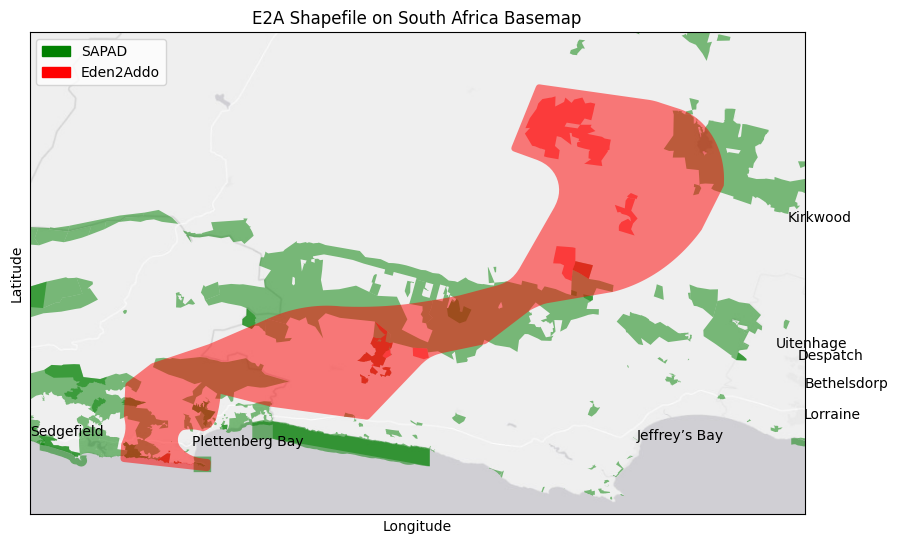

In [6]:
import numpy as np
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

# Assuming e2a_shape_df is already defined as in your previous code

# Define the bounds of South Africa (adjust if needed)
min_lon, min_lat = 22.8, -34.25#20, -34.25#23, -34.25 # approximate min longitude and latitude for South Africa
max_lon, max_lat = 25.5, -32.85#30, -20#25.25, -32.95 # approximate max longitude and latitude for South Africa

# Create the basemap
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Add coastlines and other map features
#m.drawcoastlines()
#m.drawcountries()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents()

# Plot the e2a_shape_df data on the basemap
SAPAD_shape_df.plot(ax=ax, color='green', alpha=0.5) # Plot the shapefile
e2a_shape_df.plot(ax=ax, color='red', alpha=0.5) # Plot the shapefile
#pentad_gdf[pentad_gdf.pentad == '3355_2350'].plot(ax=ax, color='blue')
#pentad_gdf[pentad_gdf.pentad == '3400_2350'].plot(ax=ax, color='orange')

addPlaceNames(town_names, (min_lon, min_lat), (max_lon, max_lat))

# Add a title and labels
plt.title('E2A Shapefile on South Africa Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
green_patch = mpatches.Patch(color='green', label='SAPAD')
red_patch = mpatches.Patch(color='red', label='Eden2Addo')
plt.legend(handles=[green_patch, red_patch], loc='upper left')

plt.show()


## Classify Pentads
We want to classify our pentads by first looking at where the corner points lie relative to the border of the borader corridor.

This can be done using the `contains` and `overlaps` Geopandas methods.

In [7]:
# Read in SABAP2 Pentad GeoJson
pentad_gdf = gpd.read_file('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/SABAP2_geojson.json')
pentad_gdf = pentad_gdf.to_crs(epsg=4326)

In [8]:
pentad_gdf.head()

,pentad,full protocol,full protocol_total_hours,adhoc protocol,incidental,additional information,2007,2008,2009,2010,...,2018,2019,2020,2021,2022,2023,2024,2025,format,geometry
0,0825_3025,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,geoJSON,"MULTIPOLYGON (((30.4167 -8.41667, 30.50003 -8...."
1,0900_2900,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((29 -9, 29.08333 -9, 29.08333 -..."
2,0900_3125,1,7,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,geoJSON,"MULTIPOLYGON (((31.4167 -9, 31.50003 -9, 31.50..."
3,0920_2840,2,6,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.33333, 28.75003 -9...."
4,0930_2840,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,geoJSON,"MULTIPOLYGON (((28.6667 -9.5, 28.75003 -9.5, 2..."


In [9]:
# Decrease shapes to consider by filtering to coarse bounding box
def filter_to_bounding_box(df, bounding_box):
    return df[df.geometry.apply(lambda row: (bounding_box.contains(row) or bounding_box.overlaps(row)))]

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
e2a_SAPAD_df = filter_to_bounding_box(SAPAD_shape_df, bounding_box)
e2a_pentad_gdf = filter_to_bounding_box(pentad_gdf, bounding_box)
corridor_boundary = e2a_shape_broad_df.geometry.iloc[0]

# Create a single area of SAPAD data
e2a_SAPAD_area = e2a_SAPAD_df.dissolve()
# Create a single area of the Eden to Addo sites
e2a_site_area = e2a_shape_site_df.dissolve()

In [10]:
# Classify Pentads
def classify_pentad(pentad_geometry, corridor_boundary, protected_areas):
  '''
  Classify SABAP2 pentads according in relation to the E2A corridor
  '''
  if corridor_boundary.contains(pentad_geometry):
    return 'contained'
  elif corridor_boundary.overlaps(pentad_geometry):
    return 'overlapping'
  else:
    return 'external'

def inc_coordinate(coord, value):
  seconds = int(coord[2:])
  minutes = int(coord[:2])
  new_seconds = seconds + value

  if new_seconds < 0:
    minutes -= 1
  elif seconds + value >= 60:
    minutes += 1
  return f'{minutes}{new_seconds % 60:02d}'

def is_neighbour(pentad_row, pentad_df):
  if pentad_row.corridor_status != 'external':
    return False
  pentad_name = pentad_row.pentad
  lat, lon = pentad_name.split('_')
  # Names for pentads to the North, South, East and West
  adjacent_pentad_names = [
      f'{inc_coordinate(lat, 5)}_{lon}',
      f'{inc_coordinate(lat, -5)}_{lon}',
      f'{lat}_{inc_coordinate(lon, 5)}',
      f'{lat}_{inc_coordinate(lon, -5)}'
  ]

  # Check adjacent pentads
  for adjacent_pentad_name in adjacent_pentad_names:
    adjacent_pentad = pentad_df[pentad_df.pentad == adjacent_pentad_name]
    # Check if the adjacent pentad exists and the corridor status if it exists.
    if adjacent_pentad.shape[0] > 0 and (adjacent_pentad.iloc[0].corridor_status == 'contained' or adjacent_pentad.iloc[0].corridor_status == 'overlapping'):
      return True
  return False

# First Pass: Classify as Internal, Overlapping, or External
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_pentad(row, corridor_boundary, e2a_SAPAD_df))
# Second Pass: Classify as Neighbouring if adjacent to an Internal or Overlapping Pentad
e2a_pentad_gdf['corridor_status'] = e2a_pentad_gdf.apply(lambda row: 'neighbour' if is_neighbour(row, e2a_pentad_gdf) else row.corridor_status, axis=1)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


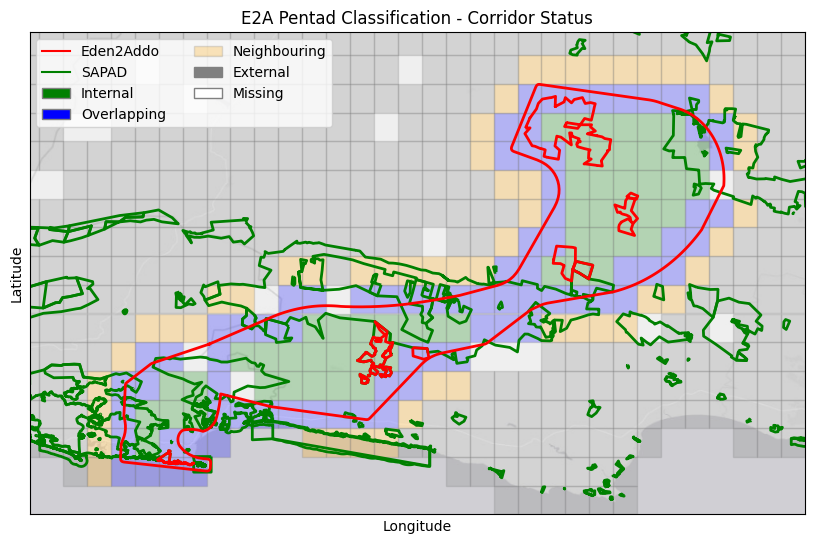

In [11]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


## Add Protected Area to Pentads
Use SAPAD regions to mark pentads as protected if they intersect with a protected area.

In [12]:
'''
def classify_protected(pentad_geometry, protected_areas):
  for area in protected_areas:
    if area.overlaps(pentad_geometry).any() or area.contains(pentad_geometry).any():
      return True
  return False

e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(lambda row: classify_protected(row, [e2a_SAPAD_df, e2a_shape_site_df]))
'''
PROTECTED_THRESHOLD = 0.5
e2a_pentad_gdf['protected'] = e2a_pentad_gdf.geometry.apply(
    lambda polygon: (polygon.intersection(e2a_SAPAD_area.geometry.iloc[0]).area + polygon.intersection(e2a_site_area.geometry.loc[0]).area) / polygon.area > PROTECTED_THRESHOLD
)

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


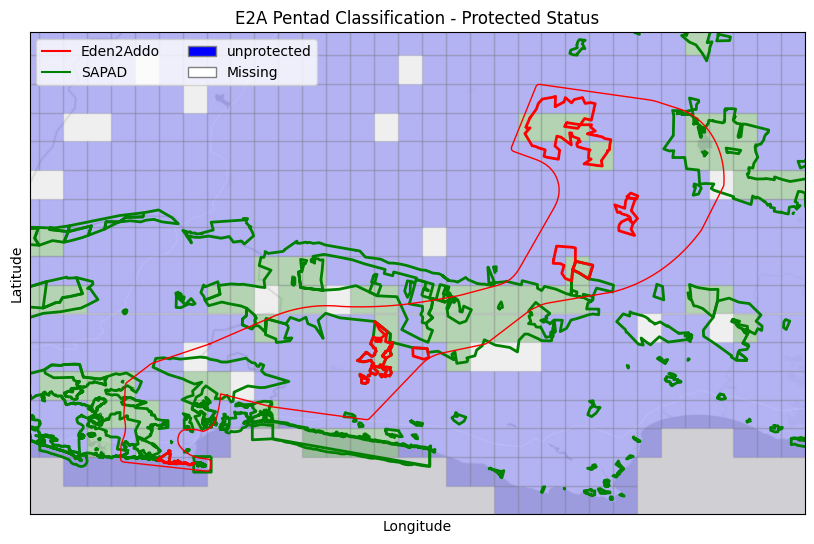

In [13]:
def protected_colour(protected):
  return 'green' if protected else 'blue'

def protected_percentage(percentage, threshold=0.9):
  return 'green' if percentage > threshold else 'blue'

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
e2a_pentad_gdf.plot(ax=ax, color=e2a_pentad_gdf.protected.apply(protected_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_site_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile
e2a_shape_broad_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=1) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Protected Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', label='Protected')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', label='unprotected')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

# Pentad Statistics

In [14]:
e2a_with_external = e2a_pentad_gdf.copy()
e2a_pentad_gdf = e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external']

In [15]:
e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})

<ipython-input-15-1010d76bf171>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf.groupby('corridor_status').agg({'pentad': 'count','full protocol': sum})


,pentad,full protocol
corridor_status,,
contained,55,605
neighbour,52,1659
overlapping,78,2608


In [16]:
e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})

<ipython-input-16-e0b18bb4fdbb>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  e2a_pentad_gdf[e2a_pentad_gdf.corridor_status != 'external'].groupby('protected').agg({'pentad': 'count', 'full protocol': sum})


,pentad,full protocol
protected,,
False,135,3147
True,50,1725


In [17]:
def create_matrix(feature, aggregate_function):
  matrix_data = []

  for protected_status in e2a_pentad_gdf['protected'].unique():
    row = []
    for corridor_status in e2a_pentad_gdf['corridor_status'].unique():
      subset = e2a_pentad_gdf[(e2a_pentad_gdf['protected'] == protected_status) & (e2a_pentad_gdf['corridor_status'] == corridor_status)]
      full_protocol_sum = subset[feature].apply(aggregate_function)
      row.append(full_protocol_sum)
    matrix_data.append(row)

  # Create a DataFrame from the matrix
  matrix_df = pd.DataFrame(matrix_data, index=e2a_pentad_gdf['protected'].unique(), columns=e2a_pentad_gdf['corridor_status'].unique())
  row_totals = matrix_df.sum(axis=1)
  col_totals = matrix_df.sum(axis=0)

  # Add row totals as a new column
  matrix_df['Total'] = row_totals

  # Add column totals as a new row
  matrix_df.loc['Total'] = col_totals

  return matrix_df

print(create_matrix('full protocol', 'sum'))
print(create_matrix('pentad', 'count'))

       neighbour  overlapping  contained   Total
False      414.0       2415.0      318.0  3147.0
True      1245.0        193.0      287.0  1725.0
Total     1659.0       2608.0      605.0     NaN
       neighbour  overlapping  contained  Total
False       39.0         54.0       42.0  135.0
True        13.0         24.0       13.0   50.0
Total       52.0         78.0       55.0    NaN


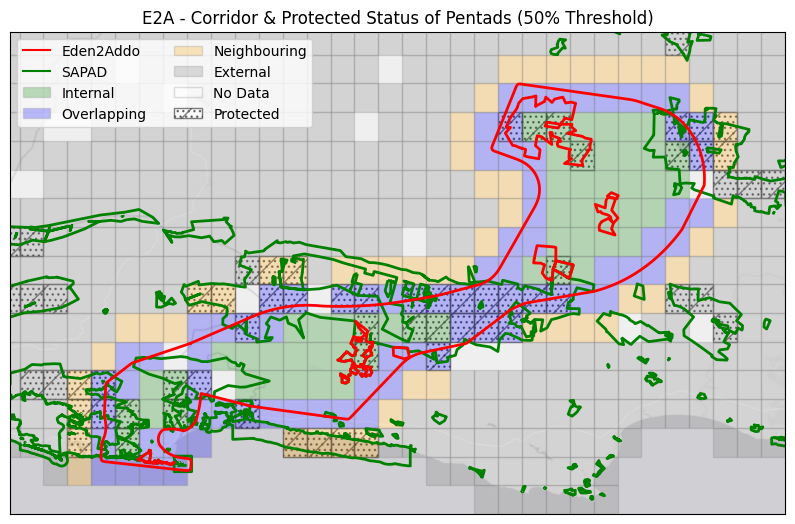

In [18]:
def corridor_colour(corridor_status):
  if corridor_status == 'contained':
    return 'green'
  elif corridor_status == 'overlapping':
    return 'blue'
  elif corridor_status == 'neighbour':
    return 'orange'
  else:
    return 'grey'


fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
# Potected
#e2a_with_external[e2a_with_external.percentage_protected > 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected > 0.5].apply(corridor_colour), hatch='/...', edgecolor='grey', alpha=0.25)
#e2a_with_external[e2a_with_external.percentage_protected <= 0.5].plot(ax=ax, color=e2a_with_external.corridor_status[e2a_with_external.percentage_protected <= 0.5].apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_with_external[e2a_with_external.protected].plot(ax=ax, facecolor='none', hatch='/...', edgecolor='black', alpha=0.5)
e2a_with_external.plot(ax=ax, color=e2a_with_external.corridor_status.apply(corridor_colour), edgecolor='grey', alpha=0.25)
e2a_SAPAD_area.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A - Corridor & Protected Status of Pentads (50% Threshold)')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

green_patch = mpatches.Patch(facecolor='green', edgecolor='grey', alpha=0.25, label='Internal')
blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='Overlapping')
orange_patch = mpatches.Patch(facecolor='orange', edgecolor='grey', alpha=0.25, label='Neighbouring')
grey_patch = mpatches.Patch(color='grey', alpha=0.25, label='External')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', alpha=0.25, label='No Data')
hatch_patch = mpatches.Patch(facecolor='white', edgecolor='black', hatch='/...', alpha=0.5, label='Protected')
legend_elements = [red_line, green_line, green_patch, blue_patch, orange_patch, grey_patch, white_patch, hatch_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()

## Get Data from SABAP2
Using the bird map API we will access the species lists for each of the pentads.

In [19]:
# Get list of pentads
pentads = e2a_pentad_gdf.pentad[e2a_pentad_gdf.corridor_status.isin(['contained', 'overlapping', 'neighbouring'])].unique()
print(f'Collected {len(pentads)} pentads')


Collected 133 pentads


In [33]:
import requests
from io import StringIO

def getPentadSpeciesList(pentad):
  response = requests.get(f'https://api.birdmap.africa/sabap2/v2/coverage/pentad/{pentad}/species?format=csv')
  pentad_species = pd.read_csv(StringIO(response.text))
  pentad_species['scientific_name'] = pentad_species.apply(lambda row: row.Genus +' '+ row.Species, axis =1 )
  pentad_species['common_name'] = pentad_species.apply(lambda row: (row.Common_species + ' ' +row.Common_group)  if pd.notna(row.Common_group) else row.Common_species, axis = 1)
  pentad_species['pentad'] = pentad
  return pentad_species.drop(columns=['Genus', 'Species', 'Common_species'])



In [42]:
'''
start = datetime.datetime.now()
pentad_species = getPentadSpeciesList(pentads[0])
for pentad in pentads[1:]:
  pentad_species = pd.concat([pentad_species, getPentadSpeciesList(pentad)])
end = datetime.datetime.now()

print(f'Collected from {start} to {end} - {end - start}')
pentad_species.to_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv')
'''
#Collected from 2025-02-26 04:56:54.879477 UTC to 2025-02-26 04:59:12.647373 UTC - 0:02:17.767896


Collected from 2025-02-26 04:56:54.879477 to 2025-02-26 04:59:12.647373 - 0:02:17.767896


In [49]:
sabap2_pentad_species = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/pentad_species.csv', index_col=0)


In [51]:
sabap2_pentad_species.head()

,Ref,Common_group,fp,fpn,fp_last,ad,adn,ad_last,scientific_name,common_name,pentad
0,722,NaN,100.0,1,2013-06-28,0.0,0,-,Telophorus zeylonus,Bokmakierie,3300_2430
1,637,NaN,100.0,1,2013-06-28,25.0,2,2016-03-08,Cisticola fulvicapilla,Neddicky,3300_2430
2,622,Apalis,100.0,1,2013-06-28,50.0,4,2016-03-08,Apalis thoracica,Bar-throated Apalis,3300_2430
3,432,Barbet,100.0,1,2013-06-28,62.5,5,2016-03-08,Tricholaema leucomelas,Acacia Pied Barbet,3300_2430
4,709,Boubou,100.0,1,2013-06-28,0.0,0,-,Laniarius ferrugineus,Southern Boubou,3300_2430


# Read in SABAP2 Data
GBIF.org (19 February 2025) GBIF Occurrence Download https://doi.org/10.15468/dl.gjy4d4

The data is only for the region around the bounded area and includes all records.

In [ ]:
from shapely.geometry import mapping, Polygon
geojson_data = {
    "type": "Feature",
    "geometry": mapping(bounding_box),
    "properties": {}  # You can add properties here if needed
}

# Print the GeoJSON this can be used to extract data from GBIF
print(json.dumps(geojson_data, indent=2))

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          22.8,
          -34.25
        ],
        [
          25.5,
          -34.25
        ],
        [
          25.5,
          -32.85
        ],
        [
          22.8,
          -32.85
        ],
        [
          22.8,
          -34.25
        ]
      ]
    ]
  },
  "properties": {}
}


In [ ]:
sabap_raw_df = pd.read_csv('/content/drive/MyDrive/ForTheBirds-E2A/SABAP2/occurrence.txt', sep='\t').dropna(axis=1, how='all').drop(
    columns=['institutionID', 'institutionCode', 'collectionID', 'datasetName', 'ownerInstitutionCode', 'occurrenceID'])

In [ ]:
import re
sabap_raw_df['hours_observing'] = sabap_raw_df.occurrenceRemarks.apply(lambda x: int(re.findall(r'\d+', x)[0]))
print(f'SABAP raw DF shape: {sabap_raw_df.shape}')

SABAP raw DF shape: (691182, 77)


In [ ]:
sabap_df = sabap_raw_df[['verbatimLocality', 'identificationRemarks', 'year', 'month', 'day', 'speciesKey', 'species', 'acceptedScientificName',
       'lastCrawled', 'repatriated', 'fieldNotes', 'hours_observing',
       'isSequenced', 'gbifRegion', 'publishedByGbifRegion', 'level0Gid',
       'level0Name', 'level1Gid', 'level1Name', 'level2Gid', 'level2Name',
       'level3Gid', 'level3Name', 'iucnRedListCategory']].rename(
           columns={
           'verbatimLocality': 'pentad',
           'fieldNotes': 'cardId'
           }
       )

In [ ]:
sabap_df = sabap_df[sabap_df.hours_observing > 1]
print(f'SABAP DF more than 2+ hours shape: {sabap_df.shape}')

SABAP DF more than 2+ hours shape: (618103, 24)


## Merge SABAP2 Data with Pentad Data
Add the `corridor status` and `protected status` to the SABAP2 species data.

In [52]:
# Merge the dataframes
sabap_df = pd.merge(sabap2_pentad_species, e2a_pentad_gdf[['pentad', 'corridor_status', 'protected']], on='pentad', how='left')

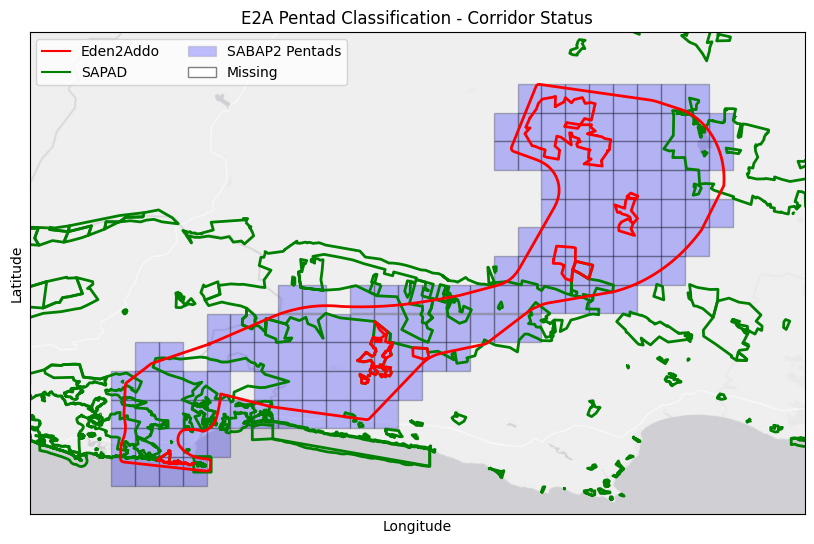

In [53]:
sabap_pentads = pentad_gdf[pentad_gdf.pentad.isin(sabap_df.pentad.unique())]

fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='i', projection='merc', epsg= 4326, ax=ax)
m.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, verbose=False)  # Use ArcGIS image for better basemap

# Plot the e2a_shape_df data on the basemap
sabap_pentads.plot(ax=ax, color='blue', edgecolor='black', alpha=0.25)
e2a_SAPAD_df.plot(ax=ax, facecolor='none', edgecolor='green', alpha=1, lw=2) # Plot the shapefile
e2a_shape_df.plot(ax=ax, facecolor='none', edgecolor='red', alpha=1, lw=2) # Plot the shapefile

# Add a title and labels
plt.title('E2A Pentad Classification - Corridor Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='', markersize=15, label='Eden2Addo')
green_line = mlines.Line2D([], [], color='green', marker='', markersize=15, label='SAPAD')

blue_patch = mpatches.Patch(facecolor='blue', edgecolor='grey', alpha=0.25, label='SABAP2 Pentads')
white_patch = mpatches.Patch(facecolor='white', edgecolor='grey', label='Missing')
legend_elements = [red_line, green_line, blue_patch, white_patch]
ax.legend(handles=legend_elements, loc='upper left', ncol=2)
plt.show()


In [ ]:
# Card counts
card_count_by_pentad = sabap_df.groupby([ 'pentad']).agg({'cardId': 'nunique'}).reset_index()
card_count_by_corridor_status = sabap_df.groupby([ 'corridor_status']).agg({'cardId': 'nunique'}).reset_index()
card_count_by_protected = sabap_df.groupby([ 'protected']).agg({'cardId': 'nunique'}).reset_index()
card_count_by_corridor_status_by_protected = sabap_df.groupby([ 'corridor_status', 'protected']).agg({'cardId': 'nunique'}).reset_index()



In [ ]:
card_count_by_corridor_status_by_protected.pivot_table(index='protected', columns='corridor_status', values='cardId')

corridor_status,contained,neighbour,overlapping
protected,,,
False,327.0,407.0,2252.0
True,287.0,1079.0,182.0


## Calculate Reporting Rate
Calcualtes the $\text{Reporting Rate} = \frac{\text{Number  of Species Records}}{\text{Number of Cards}}$

In [ ]:
def calculateReportingRate(num_reports, corridor_status=None, protected=None):
  if corridor_status is not None and protected is not None:
    card_count = card_count_by_corridor_status_by_protected[(card_count_by_corridor_status_by_protected.corridor_status == corridor_status) & (card_count_by_corridor_status_by_protected.protected == protected)].cardId.values[0]
  elif corridor_status is not None:
    card_count = card_count_by_corridor_status[card_count_by_corridor_status.corridor_status == corridor_status].cardId.values[0]
  elif protected is not None:
    card_count = card_count_by_protected[card_count_by_protected.protected == protected].cardId.values[0]
  else:
    card_count = card_count_by_pentad.cardId.sum()
  return num_reports / card_count

In [ ]:
sabap_species_df = sabap_df.groupby(['species', 'corridor_status', 'protected']).agg({'cardId': 'nunique'}).reset_index().rename(columns={'cardId': 'report_count'})
sabap_species_df.head()

,species,corridor_status,protected,report_count
0,Accipiter melanoleucus,contained,False,5
1,Accipiter melanoleucus,contained,True,8
2,Accipiter melanoleucus,neighbour,False,8
3,Accipiter melanoleucus,neighbour,True,38
4,Accipiter melanoleucus,overlapping,False,99


In [ ]:
sabap_species_df['reporting_rate'] = sabap_species_df.apply(lambda row: calculateReportingRate(row.report_count, row.corridor_status, row.protected), axis=1)

array([[<Axes: title={'center': 'reporting_rate'}>]], dtype=object)

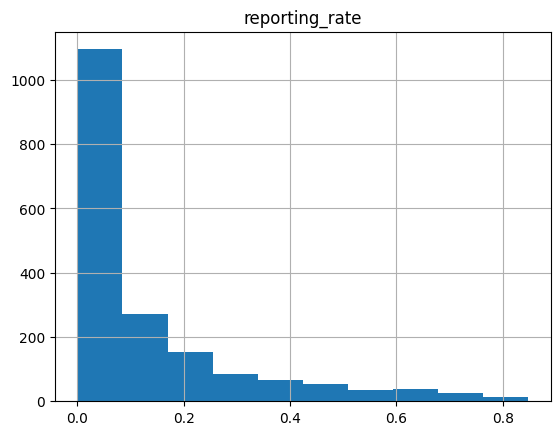

In [ ]:
sabap_species_df.hist(column='reporting_rate')

## Read in Eden to Addo Species

In [ ]:
e2a_species = pd.read_excel('/content/drive/MyDrive/ForTheBirds-E2A/Corridors all threatened spp list.xlsx', 'birds')\
  .rename(columns={'species.1': 'status'})\
  .drop(columns=['comment'])
e2a_species.head()

,species,status,name
0,Ardeotis kori,NT,Kori bustard
1,Neotis ludwigii,EN,Ludwig’s bustard
2,Neotis denhami,NT,Denham’s bustard
3,Anthropoides paradiseus,VU,Blue crane
4,Turnix hottemtottus,Endemic,Hottentot buttonquail


In [ ]:
e2a_species = pd.merge(e2a_species, sabap_species_df, how='inner', on='species')

In [ ]:
e2a_species

,species,status,name,corridor_status,protected,report_count,reporting_rate
0,Ardeotis kori,NT,Kori bustard,contained,False,16,0.048930
1,Ardeotis kori,NT,Kori bustard,contained,True,1,0.003484
2,Ardeotis kori,NT,Kori bustard,neighbour,False,12,0.029484
3,Ardeotis kori,NT,Kori bustard,overlapping,False,24,0.010657
4,Neotis ludwigii,EN,Ludwig’s bustard,contained,False,36,0.110092
...,...,...,...,...,...,...,...
84,Crithagra totta,Endemic,Cape siskin,contained,True,12,0.041812
85,Crithagra totta,Endemic,Cape siskin,neighbour,False,17,0.041769
86,Crithagra totta,Endemic,Cape siskin,neighbour,True,71,0.065802
87,Crithagra totta,Endemic,Cape siskin,overlapping,False,120,0.053286


In [ ]:
e2a_species['corridor_status'] = e2a_species.corridor_status.apply(lambda x: 'Internal' if x == 'contained' else x.capitalize())
e2a_species['protected'] = e2a_species.protected.apply(lambda x: 'Protected' if x else 'Unprotected')
e2a_species_RR = e2a_species.drop(columns=['status', 'species', 'report_count'])\
  .pivot(index='name', columns=['corridor_status', 'protected'], values='reporting_rate')\
  .reset_index()\
  .fillna(0)
e2a_species_RR.columns = ['-'.join(col).strip('-') for col in e2a_species_RR.columns]

e2a_species_RR

,name,Internal-Unprotected,Internal-Protected,Neighbour-Unprotected,Overlapping-Unprotected,Neighbour-Protected,Overlapping-Protected
0,African rock pipit,0.039755,0.000000,0.103194,0.007993,0.008341,0.005495
1,Black harrier,0.030581,0.000000,0.031941,0.007105,0.007414,0.016484
2,Blue crane,0.238532,0.125436,0.206388,0.229574,0.019462,0.071429
3,Cape cormorant,0.000000,0.062718,0.002457,0.248224,0.503244,0.038462
4,Cape gannet,0.000000,0.003484,0.002457,0.151421,0.147359,0.010989
5,Cape rockjumper,0.012232,0.000000,0.022113,0.000000,0.050046,0.005495
6,Cape siskin,0.045872,0.041812,0.041769,0.053286,0.065802,0.142857
7,Cape sugarbird,0.067278,0.205575,0.085995,0.257105,0.197405,0.109890
8,Crowned cormorant,0.000000,0.000000,0.000000,0.000000,0.000927,0.000000
9,Denham’s bustard,0.082569,0.163763,0.007371,0.007105,0.018536,0.000000


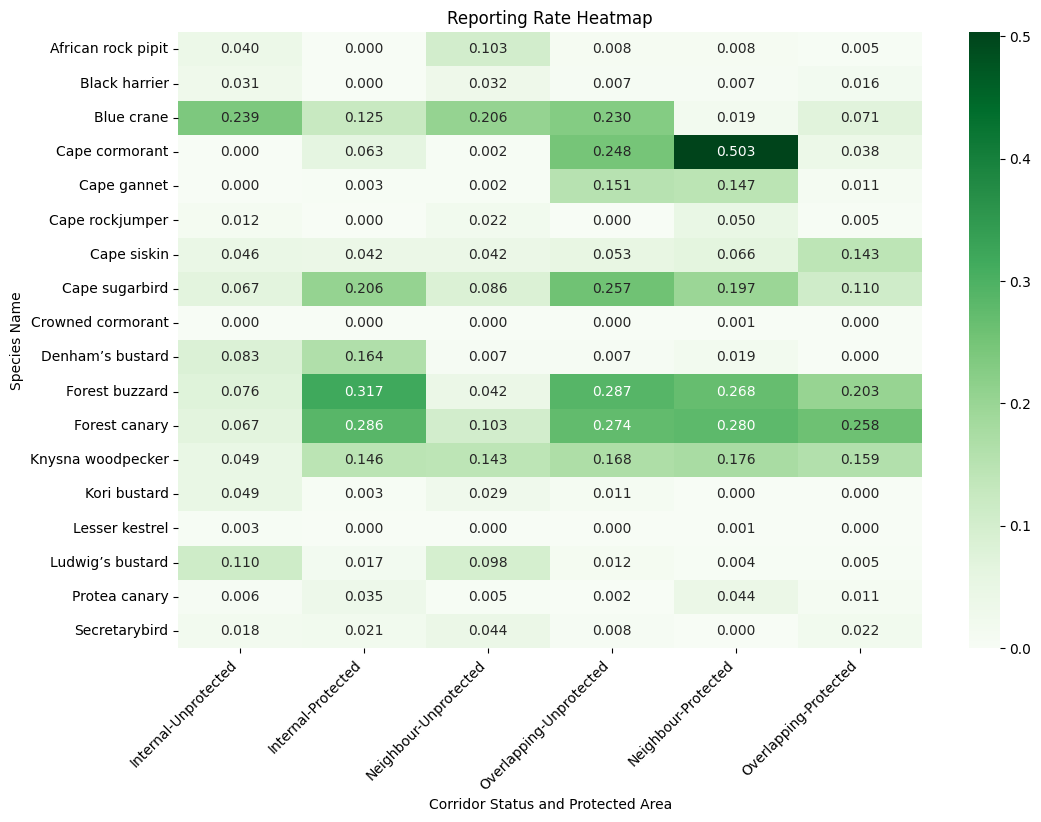

In [ ]:
import seaborn as sns

# Assuming e2a_species_RR DataFrame is already created as in your provided code

# Create the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(e2a_species_RR.set_index('name'), annot=True, cmap="Greens", fmt=".3f")
plt.title('Reporting Rate Heatmap')
plt.xlabel('Corridor Status and Protected Area')
plt.ylabel('Species Name')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()
